In [2]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import interpolate
from chain_analysis import contour_plot, gelman_rubin
import time
import pymultinest
from collections import OrderedDict
%matplotlib nbagg
%load_ext autoreload

In [3]:
plt.rcParams['nbagg.transparent'] = False
plt.rcParams['figure.facecolor'] = 'w'

In [4]:
def make_data(N, m=1, c=1, y_err=0.005, delt_x=0.001, y_err_actual=0.005, delt_x_actual=0.001, x_mu=0.5, x_sig=0.25):
    """
    Function to create straight line data.
    
    Parameters
    ----------
    N : int
        Number of data points
    m : float
        Gradient
    c : float
        Intercept
    y_err : float
        The errorbar on y (not necessarily the same as the scatter)
    x_err : float
        The errorbar on x (not necessarily the same as the scatter)
    y_err_actual : float
        Standard deviation to scatter the y values by
    x_err_actual : float
        Standard deviation to scatter the x values by
    x_mu : float
        Mean of the Gaussian prior to be used in the drawing of the x values
    x_sig : float
        Standard deviation of the Gaussian prior to be used in the drawing of the x values. Set to zero for uniform.
    
    """
    
    if x_sig == 0:
        x = np.random.uniform(0, 1.0, N)
    else:
        x = np.random.randn(N)*x_sig + x_mu
    x_err = (1+x)*delt_x
    x_err_actual = (1+x)*delt_x_actual
    
    y = m*x + c + np.random.randn(N)*y_err_actual
    x += np.random.randn(N)*x_err_actual
    return np.column_stack((x, y, [y_err]*N, x_err))

In [5]:
class FitData:
    
    
    def __init__(self, dat, model='std', prior_choice='uniform', bounds=[], gaussian_prior_params=[0.5, 0.25]):
        """
        Class to encapsulate multinest fitting
        
        Parameters
        ----------
        dat : np.array
            Dataset with first column x, second y, third y_err, fourth x_err
        model : str
            Which likelihood function to use 'std' or 'zbeams'
        prior_choice : str
            Which prior to assume for the x values 'uniform', 'gaussian' or 'hyperprior' (fits the parameters)
        bounds : collections.OrderedDict, optional
            Dictionary of uniform bounds to give to Multinest for each parameter
        """

        if len(bounds) == 0:
            self.bounds = OrderedDict([
                    ('m', [0, 2]),
                    ('c', [0,2]),
                    ('x', [-1.4, 1.4]),
                    ('x_mu', [0, 1]),
                    ('x_sig', [0.01, 3.0]),
                ])
        else:
            self.bounds = bounds

        self.dat = dat
        self.prior_choice = prior_choice
        
        self.x_mu_fixed = gaussian_prior_params[0]
        self.x_sig_fixed = gaussian_prior_params[1]
        
        if model == 'std':
            self.lnprob = self.lnprob_std
            self.ndim = 2
        elif self.prior_choice == 'uniform' or self.prior_choice == 'gaussian':
            self.lnprob = self.lnprob_zbeams
            self.ndim = 2 + len(dat)
        else:
            self.lnprob = self.lnprob_zbeams
            self.ndim = 4 + len(dat)
            


    def lnprob_std(self, cube, ndim, nparams):
        """
        Log likelihood for multinest

        Parameters
        ----------
        cube : array-like
            Input parameter cube
        ndim : int
            Number of dimensions
        nparams : int
            Number of parameters actually varying

        Returns
        -------
        float
            Log likelihood
        """
        
        dat = self.dat 
        p = cube
        
        m, c = p[:2]
        y_fit = m*dat[:,0] + c

        chi2 = np.sum(((dat[:,1]-y_fit)/dat[:,2])**2)
        return  -0.5*chi2

    
    def lnprob_zbeams(self, cube, ndim, nparams):
        """
        Log likelihood for multinest

        Parameters
        ----------
        cube : array-like
            Input parameter cube
        ndim : int
            Number of dimensions
        nparams : int
            Number of parameters actually varying

        Returns
        -------
        float
            Log likelihood
        """
            
        dat = self.dat 

        p = np.zeros(ndim)
        for i in range(ndim):
            p[i] = cube[i]
            
        if self.prior_choice == 'uniform' or self.prior_choice == 'gaussian':
            m, c = p[:2]
            x_fit = p[2:]
        else:
            m, c, x_mu, x_sig = p[:4]
            x_fit = p[4:]

        y_fit = m*x_fit + c
        
        chi2_y = np.sum(((dat[:,1]-y_fit)/dat[:,2])**2)
        chi2_x = np.sum(((dat[:,0]-x_fit)/dat[:,3])**2)
        
        
        
        loglike = -0.5*(chi2_y + chi2_x)

        if self.prior_choice == 'uniform':
            return loglike
        elif self.prior_choice == 'gaussian':
            pri = -0.5*np.sum(((x_fit - self.x_mu_fixed)/self.x_sig_fixed)**2)
            return pri + loglike
        else:
            pri = len(x_fit)*np.log(1/np.sqrt(2*np.pi*x_sig**2))-0.5*np.sum(((x_fit - x_mu)/x_sig)**2)
            return pri + loglike
        
        

    def prior(self, cube, ndim, nparams):
        """
        Prior for multinest

        Parameters
        ----------
        cube : array-like
            Input parameter cube
        ndim : int
            Number of dimensions
        nparams : int
            Number of parameters actually varying

        Returns
        -------
        array
            Transformed parameter cube

        """
        keys = list(self.bounds.keys())
        
        if self.prior_choice == 'uniform' or self.prior_choice == 'gaussian':
            params = ['m', 'c']
        else:
            params = ['m', 'c', 'x_mu', 'x_sig']
        
        for i in range(len(params)):
            lower = self.bounds[params[i]][0]
            upper = self.bounds[params[i]][1]
            cube[i] = cube[i]*(upper-lower)+lower
        if ndim>2:
            for i in range(len(params), ndim):
                lower = self.bounds['x'][0]
                upper = self.bounds['x'][1]
                cube[i] = cube[i]*(upper-lower)+lower
        return cube



    def fit(self, chain_name='chain-', n_live_points=500, multimodal=True):
        """
        Actually do the inference
        
        Parameters
        ----------
        chain_name : str
            Root name for chain storage (multinest makes multiple files so this should be something like 'chain-')
        n_live_points : int
            Number of live points for nested sampling. Minimum should be 25*ndim
        multimodal : bool
            Allow multimodal mode in multinest
        """

        t1 = time.time()
        
        pymultinest.run(self.lnprob, self.prior, self.ndim, importance_nested_sampling = True, init_MPI = False,
                        resume = False, verbose = False, sampling_efficiency = 'parameter', 
                        n_live_points = n_live_points, outputfiles_basename = chain_name, multimodal = multimodal)
        print('Time taken', time.time()-t1)

In [6]:
def run_test(datasets, test_number, model='std', prior_choice='uniform', plot_only=False, smth=0, m=1, c=1):
    """
    Runs a particular test case for a set of datasets, plotting the 2 sigma contours.
    
    Parameters
    ----------
    datasets : list
        List of datasets to iterate through
    test_number : int
        Which test are we running (used in file naming)
    model : str
        Which likelihood function to use 'std' or 'zbeams'
    prior_choice : str
        Which prior to assume for the x values 'uniform', 'gaussian' or 'hyperprior' (fits the parameters)
    plot_only : boolean
        Allows plotting from existing chains without having to rerun
    smth : float
        Smoothing scale for contours
    m : float
        True gradient (for plotting)
    c : float
        True intercept (for plotting)
    """
    
    cols=['#185aa9','#008c48','#ee2e2f','#f47d23','#662c91','#a21d21','#b43894','#010202']
    
    chains = []
    for i in range(len(datasets)):
        chain_name = 'test-%d-straight-line-data-%d-' %(test_number, i+1)
        d = datasets[i]
        if not plot_only:
            fd = FitData(d, model=model, prior_choice=prior_choice)
            fd.fit(chain_name=chain_name)
        chains.append(np.loadtxt(chain_name+'post_equal_weights.dat'))

    plt.figure()
    N = len(chains)
    for i in range(N):
        chain = chains[i]
        contour_plot.contour(chain, [0,1], smooth=smth, line=True, level=2, col=cols[i])
    plt.plot(m, c, '*k')
#     plt.xlim([1.7, 2.4])
#     plt.ylim(0.8, 1.2)
    plt.title('Test %d' %test_number)    

# Tests

In [7]:
m = 1
c = 1

In [8]:
datasets = []
for i in range(1,6):
    dat = np.loadtxt('general_datasets/data_str_line_%d.txt' %i)
    dat = np.column_stack((dat[:,0], dat[:,1], [0.005]*len(dat), 0.01*(1+dat[:,0])))
    #dat = make_data(10, delt_x_actual=0.01, delt_x=0.01)
    datasets.append(dat)

## Standard MCMC

<IPython.core.display.Javascript object>


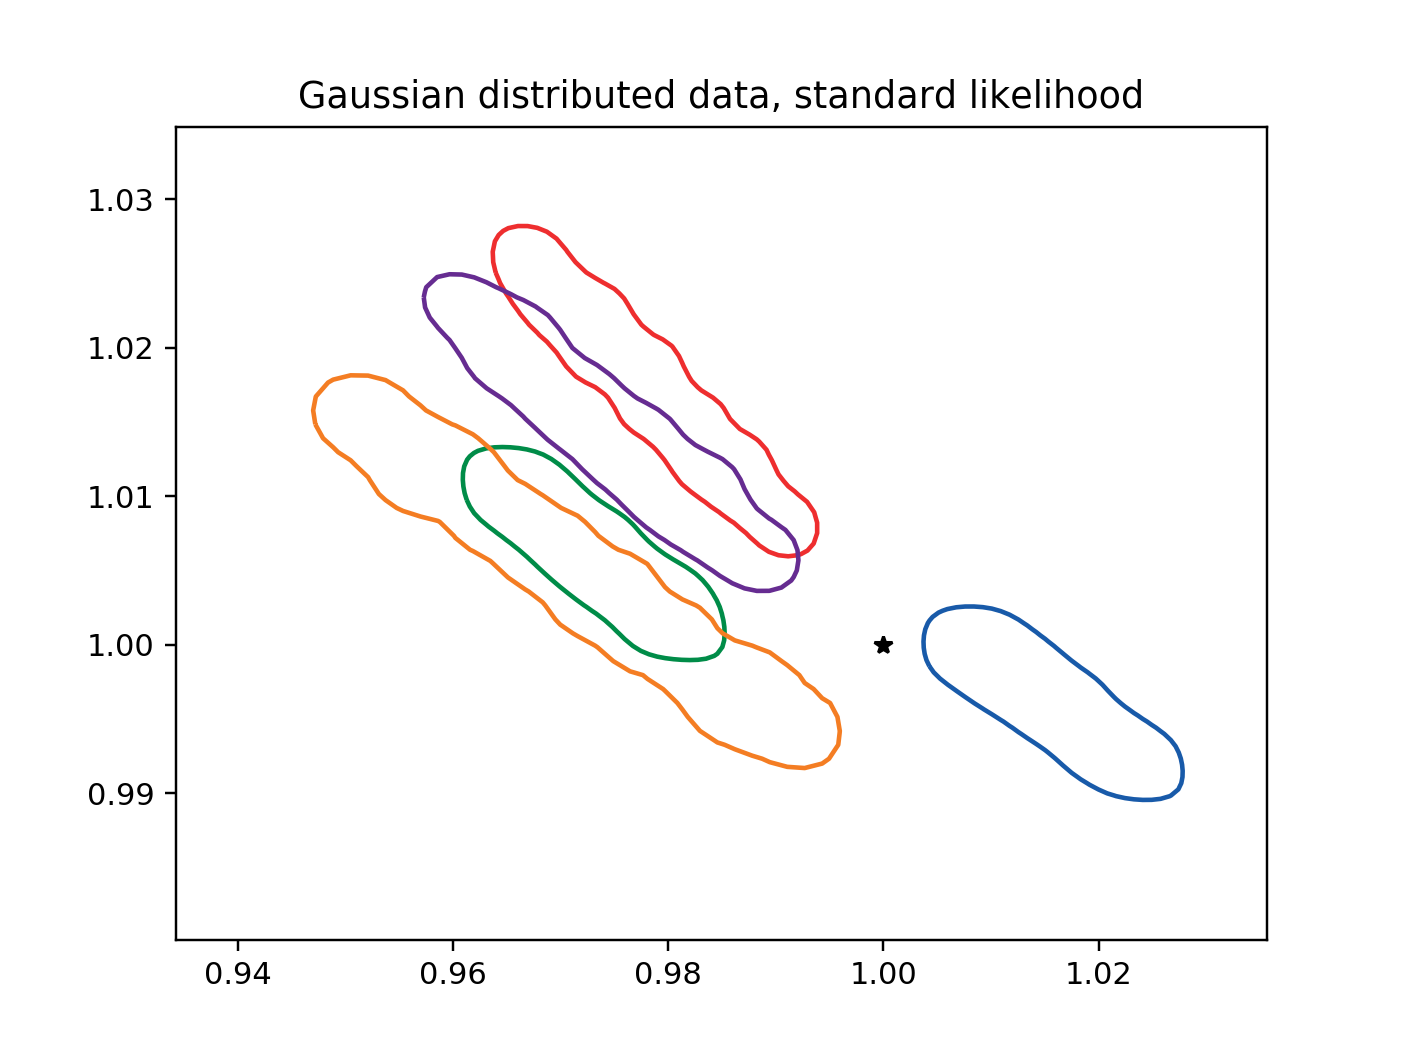

In [9]:
run_test(datasets=datasets, test_number=0, model='std', plot_only=True, smth=2.5e3)
plt.title('Gaussian distributed data, standard likelihood')

## Test 3: Fixed Gaussian Prior

<IPython.core.display.Javascript object>


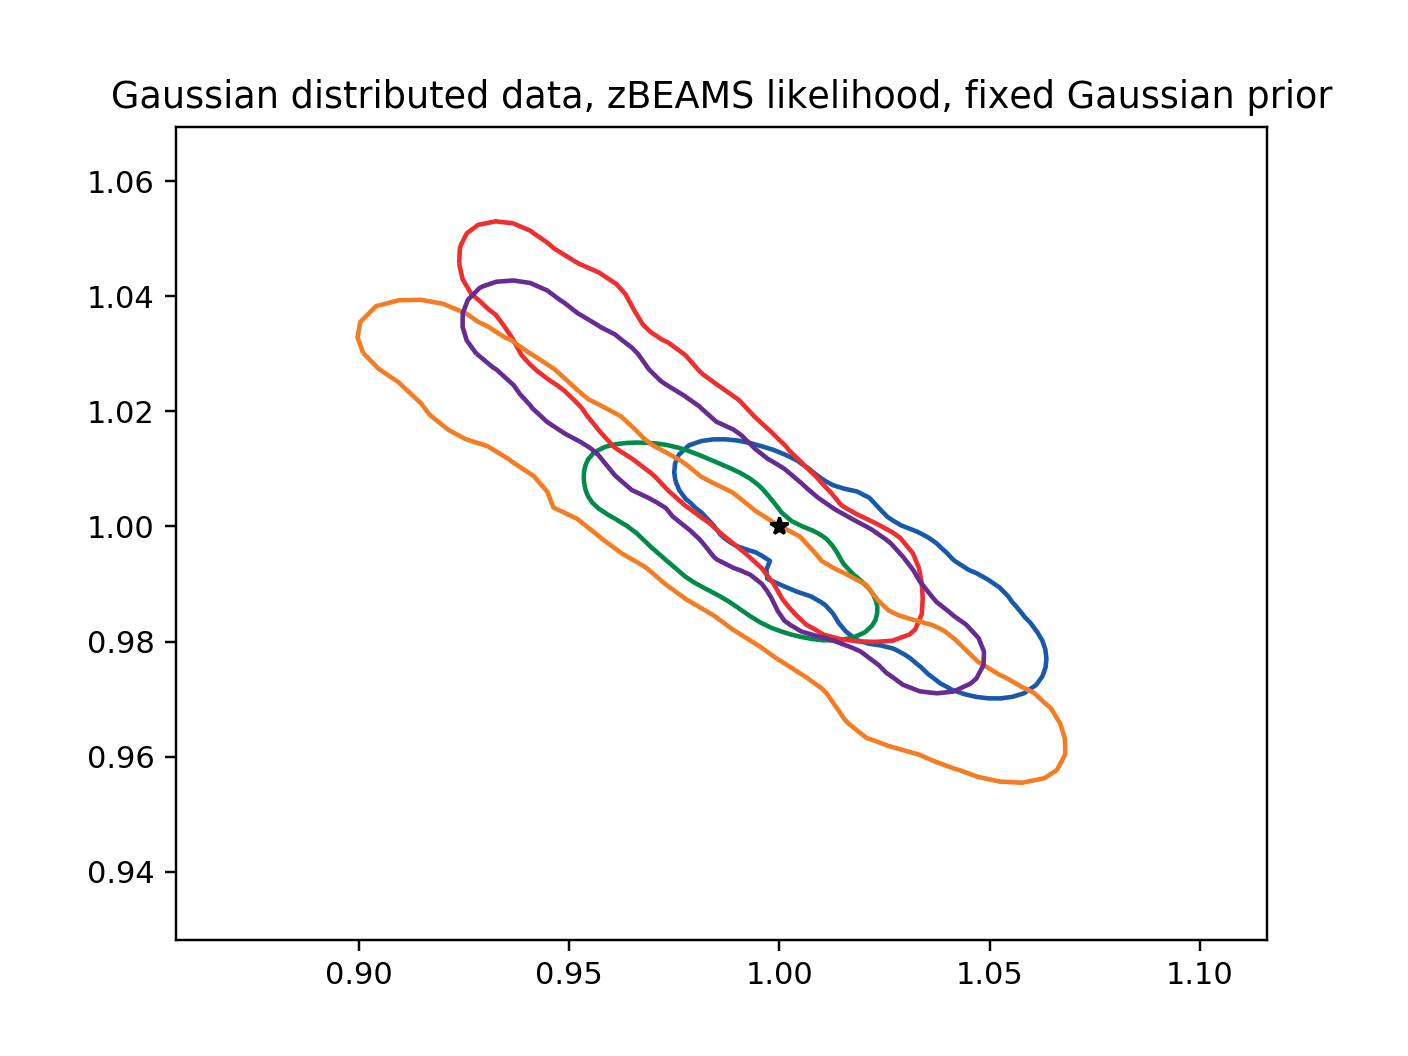

In [10]:
run_test(datasets=datasets, test_number=3, model='zbeams', prior_choice='gaussian', plot_only=True, smth=7e3)
plt.title('Gaussian distributed data, zBEAMS likelihood, fixed Gaussian prior')

## Test 4: Gaussian hyperprior

<IPython.core.display.Javascript object>


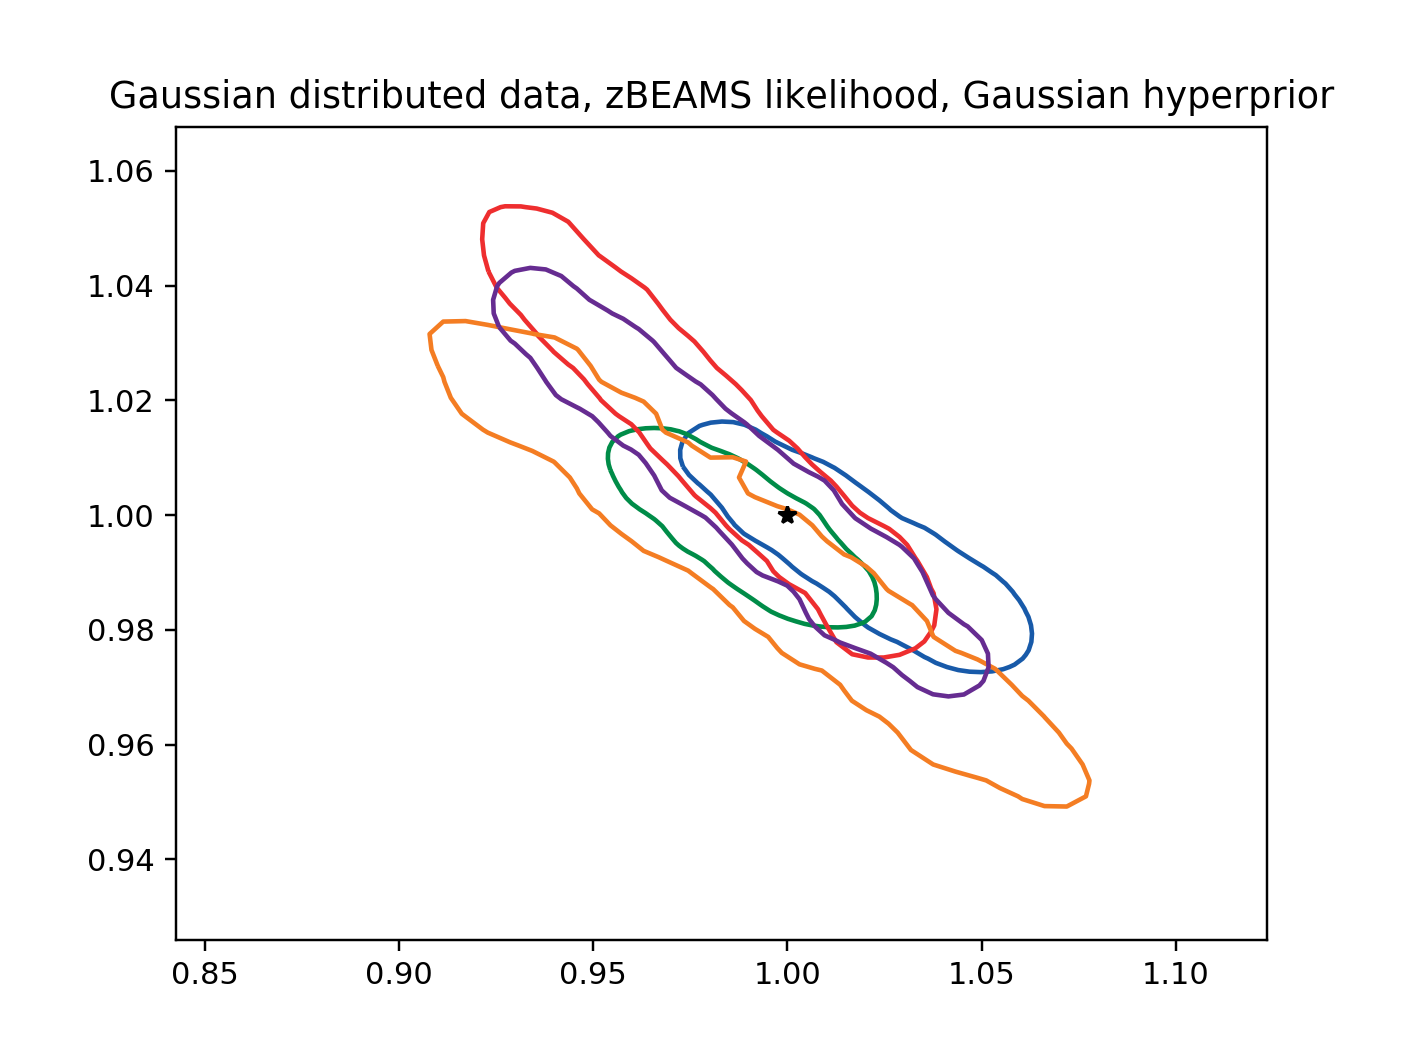

In [17]:
run_test(datasets=datasets, test_number=4, model='zbeams',prior_choice='hyperprior', plot_only=True, smth=7e3)
plt.title('Gaussian distributed data, zBEAMS likelihood, Gaussian hyperprior')

## Test 9: Uniform distributed data, fixed Gaussian prior

### First let's generate some data and test standard likelihood

In [18]:
datasets_uni = []
for i in range(1,6):
    dat = make_data(10, delt_x_actual=0.01, delt_x=0.01, x_sig=0, x_mu=0)
    datasets_uni.append(dat)

<IPython.core.display.Javascript object>


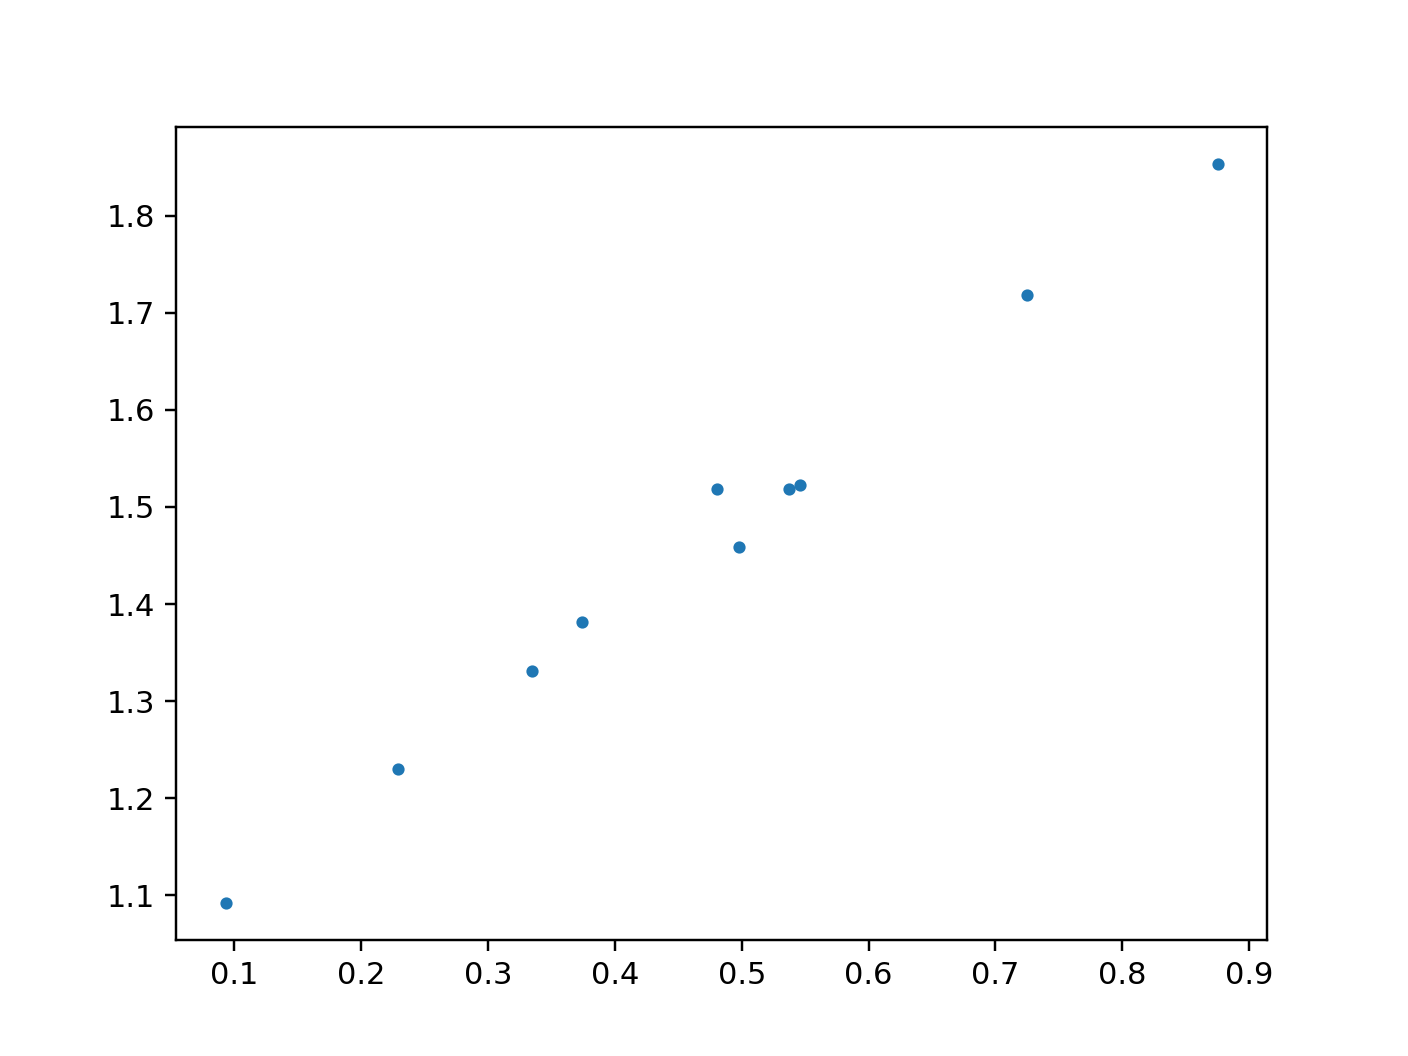

In [19]:
plt.figure()
dat = datasets_uni[0]
plt.plot(dat[:,0], dat[:,1], '.')

Time taken 1.0847387313842773
Time taken 1.120713472366333
Time taken 1.0738263130187988
Time taken 1.0806269645690918
Time taken 1.0796620845794678


<IPython.core.display.Javascript object>


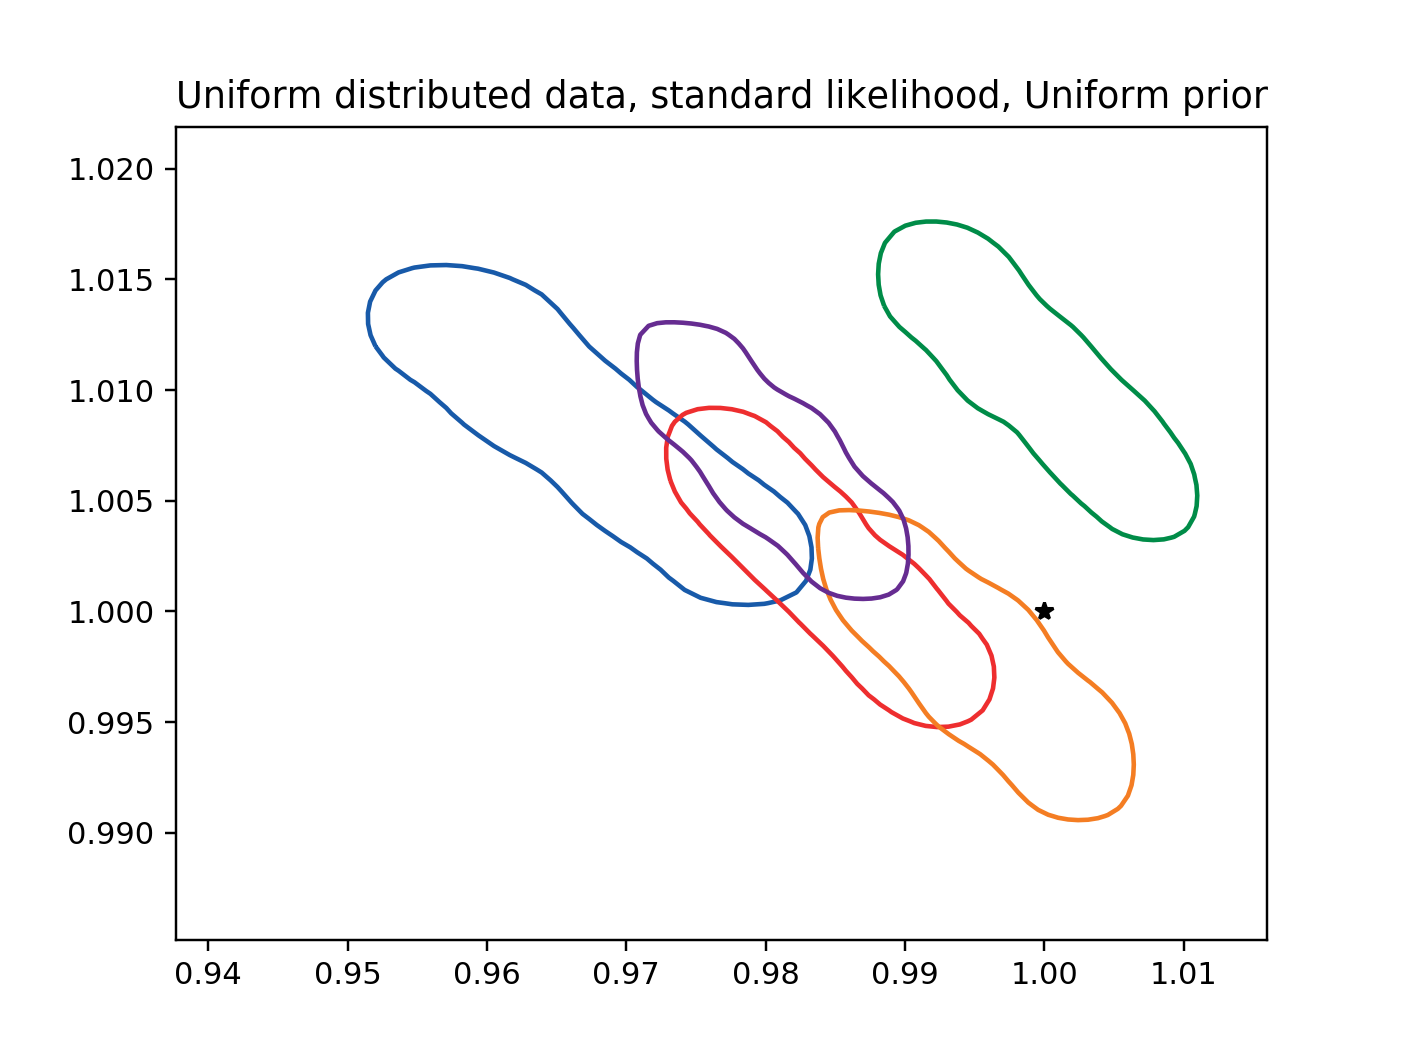

In [20]:
run_test(datasets=datasets_uni, test_number=90, model='std',prior_choice='uniform', plot_only=False, smth=2.5e3)
plt.title('Uniform distributed data, standard likelihood, Uniform prior')

### Let's check zBEAMS with a uniform prior

<IPython.core.display.Javascript object>


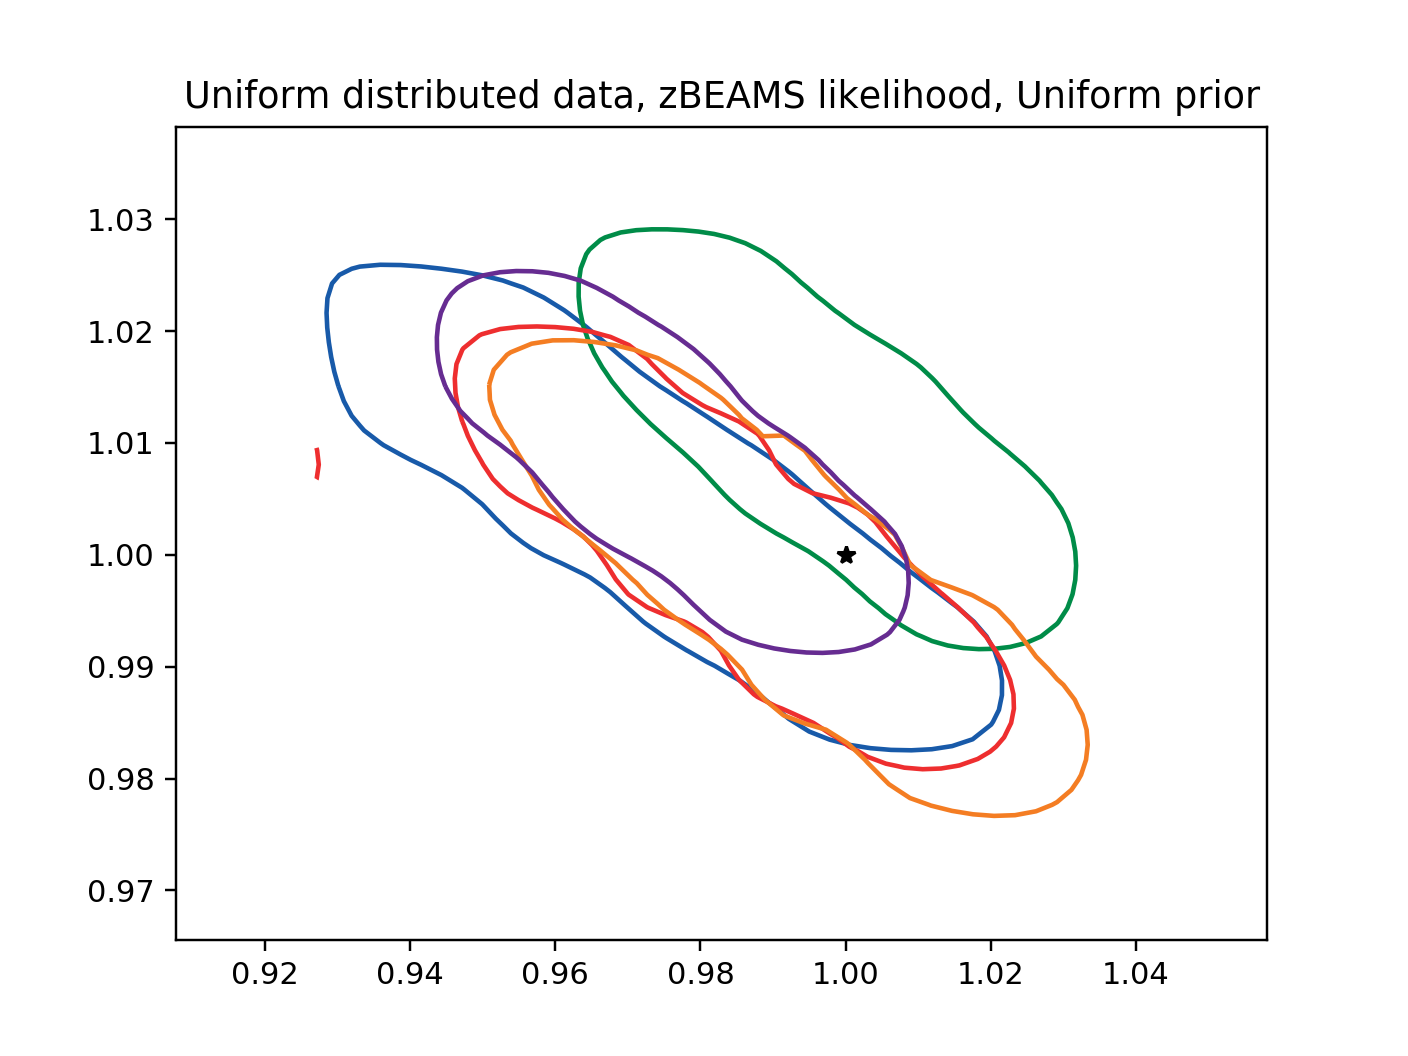

In [22]:
run_test(datasets=datasets_uni, test_number=91, model='zbeams',prior_choice='uniform', plot_only=True, smth=7e3)
plt.title('Uniform distributed data, zBEAMS likelihood, Uniform prior')

### Now run test 9

Time taken 84.40575695037842
Time taken 74.033522605896
Time taken 81.40994501113892
Time taken 76.66425633430481
Time taken 81.37425374984741


<IPython.core.display.Javascript object>


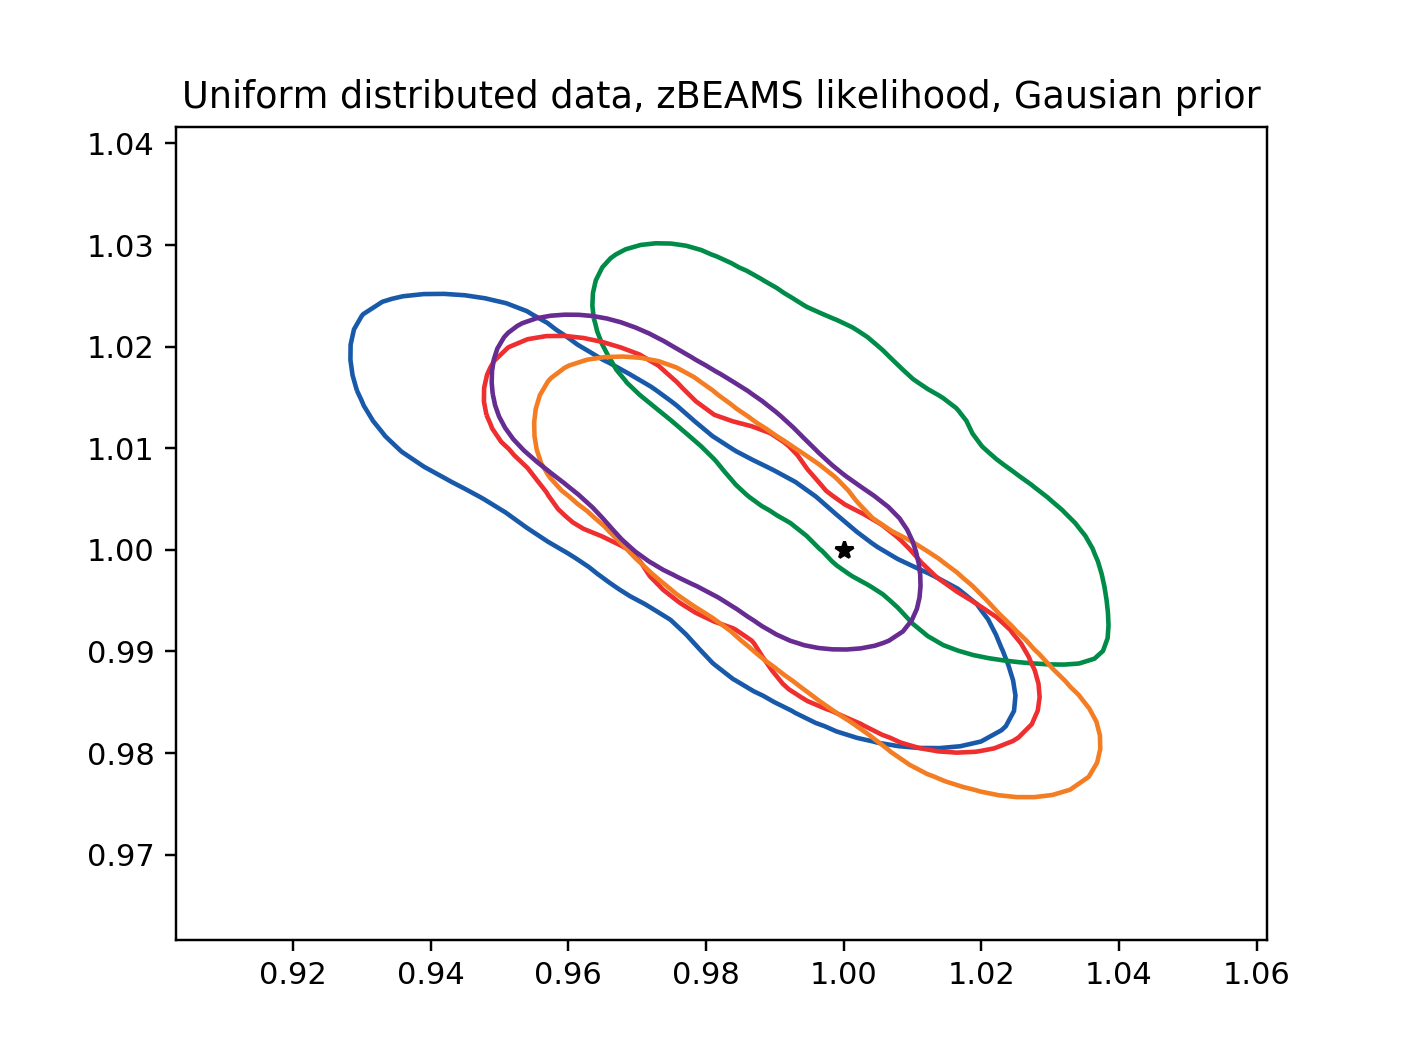

In [31]:
run_test(datasets=datasets_uni, test_number=9, model='zbeams',prior_choice='gaussian', plot_only=False, smth=7e3)
plt.title('Uniform distributed data, zBEAMS likelihood, Gausian prior')

## Test 10: Uniform distributed data, Gaussian hyperprior

Time taken 110.44593358039856
Time taken 85.16529321670532
Time taken 110.23127055168152
Time taken 75.23816514015198
Time taken 81.48984122276306


<IPython.core.display.Javascript object>


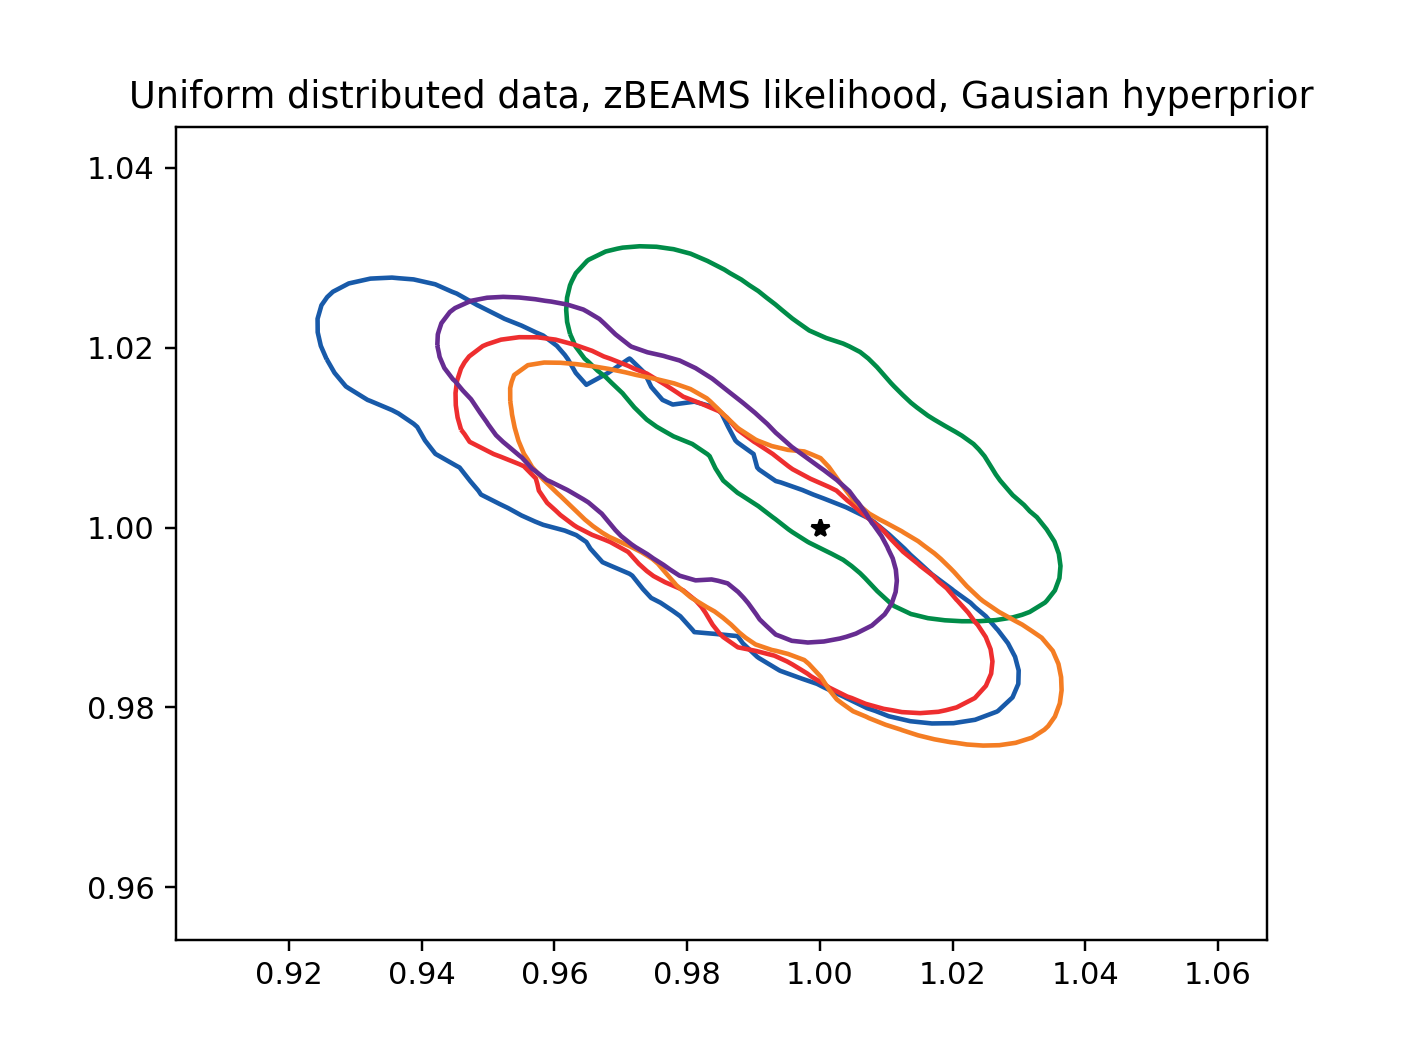

In [32]:
run_test(datasets=datasets_uni, test_number=10, model='zbeams',prior_choice='hyperprior', plot_only=False, smth=7e3)
plt.title('Uniform distributed data, zBEAMS likelihood, Gausian hyperprior')

### Look at the hyperparameters

In [35]:
chain = np.loadtxt('test-10-straight-line-data-2-post_equal_weights.dat')

In [41]:
x = datasets[2][:,0]
max_post = np.argmax(chain[:,-1])
print('Data x_mu', x.mean(), 'x_sig', x.std())
print('Hyperparameter max posterior: x_mu', chain[max_post,2], 'x_sig', chain[max_post,3])

Data x_mu 0.6952 x_sig 0.230994285644
Hyperparameter max posterior: x_mu 0.588557606549 x_sig 0.281048565318


<IPython.core.display.Javascript object>


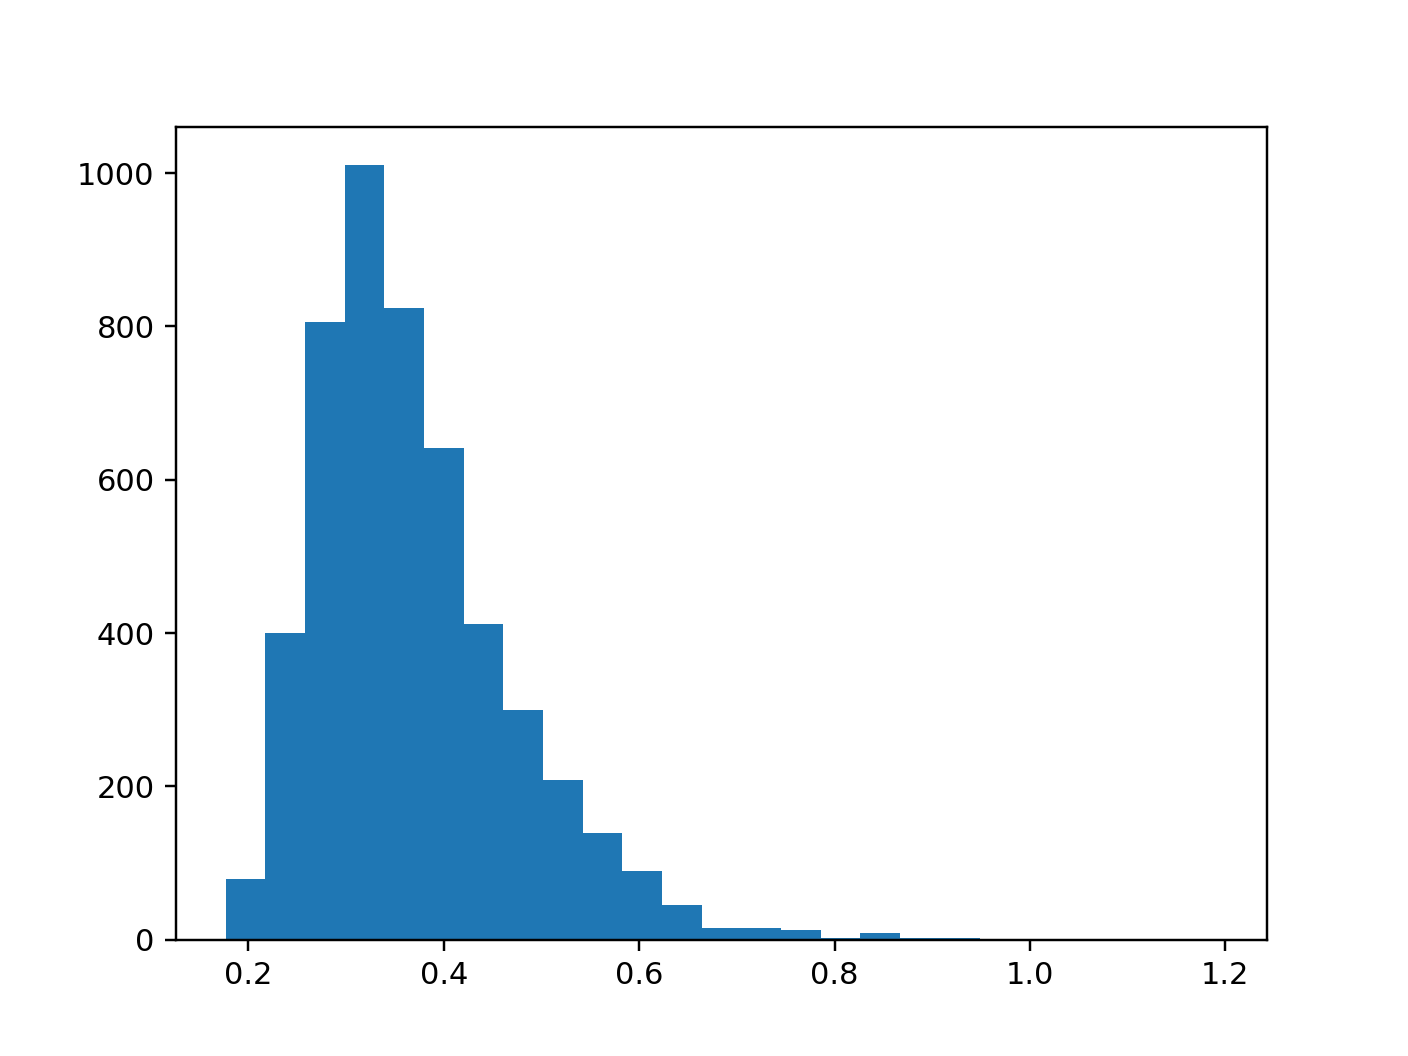

In [39]:
plt.figure()
plt.hist(chain[:,3], 25);